In [1]:
import pandas as pd
import numpy as np
import pickle
import janitor
import datetime

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.decomposition import FactorAnalysis
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

%matplotlib inline
# %matplotlib notebook

In [2]:
with open('data/san-pedro.pkl', 'rb') as file:
    df = pickle.load(file)

In [3]:
scaler = StandardScaler()

scaled_df = pd.DataFrame(scaler.fit_transform(df),
                         columns=df.columns,
                         index=df.index)


In [4]:
def pca_plot(df: pd.core.frame.DataFrame):

    pca = PCA()
    pca.fit(df)

    loadings = pd.DataFrame(pca.components_, columns=df.columns)
    explained_variance = pd.DataFrame(pca.explained_variance_)

    fig, ax = plt.subplots(figsize=(10, 4))
    ax = explained_variance.plot.bar(legend=False, ax=ax,
                                     color='#BEBEBE', edgecolor='black',
                                     width=0.75)
    ax.set_xticklabels(('Comp. ' + str(f) for f in range(1, 16)))
    ax.set_ylabel('Varianza')
    fig.suptitle('Varianza de componentes', fontsize=15)

    return pca


def screeplot(pca: PCA()):
    fig, ax = plt.subplots(figsize=(10, 4))

    ax.plot(pca.explained_variance_ratio_, 'o-', linewidth=2, color='blue')

    ax.set_xticks(range(15))
    ax.set_xticklabels(range(1, 16))

    ax.axvline(4, linestyle='--', color='#F47174', ymax=pca.explained_variance_ratio_[4]/pca.explained_variance_ratio_[0])
    ax.annotate(f'$\sigma^2={pca.explained_variance_ratio_.cumsum()[4]:0.2f}$',
                xy=(4+0.15, pca.explained_variance_ratio_[4]+0.01))

    ax.set_xlabel('Componente')
    ax.set_ylabel('Varianza explicada (porcentual)')

    fig.suptitle('Gráfica de codo para Componentes Principales', fontsize=18)


def pca_loadings_plot(df: pd.core.frame.DataFrame, n_components=5):

    pca = PCA()
    pca.fit(df)

    loadings = pd.DataFrame(pca.components_[:n_components, :],
                            columns=df.columns)

    fig, axes = plt.subplots(n_components, 1, figsize=(12, 10),
                             sharex=True)
    for i, ax in enumerate(axes):
        pc_loadings = loadings.loc[i, :]
        colors = ['#56BDC2' if l > 0 else '#E77E72' for l in pc_loadings]
        pc_loadings.plot.bar(ax=ax, color=colors)
        ax.set_ylabel(f'PC{i+1}', fontsize=12)
        ax.yaxis.set_label_position('right')
        ax.set_xlabel(None)
        ax.set_axisbelow(True)
        ax.grid()

    fig.suptitle(f'Cargas para los {n_components} Componentes Principales\ncon mayor varianza',
                 fontsize=15)
    fig.subplots_adjust(top=0.925)


In [5]:
sns.reset_orig()

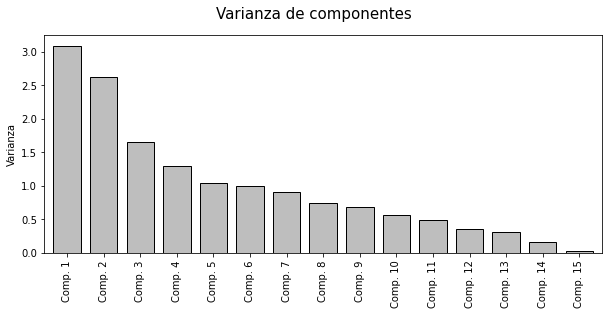

In [6]:
pca = pca_plot(df=scaled_df)

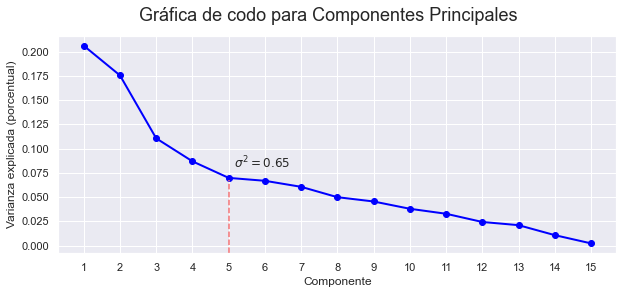

In [7]:
sns.set()
screeplot(pca)

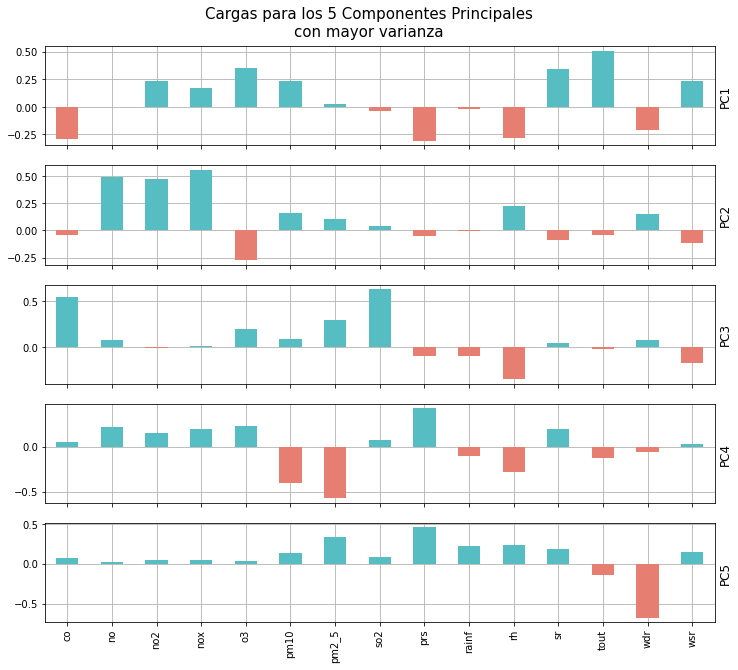

In [8]:
sns.reset_orig()
pca_loadings_plot(scaled_df)

In [9]:
def fa_linear_combinations(df: pd.core.frame.DataFrame, n_components=15):

    factor_analysis = FactorAnalysis(n_components=n_components)
    factor_analysis.fit_transform(df)
  
    factors = pd.DataFrame(factor_analysis.components_, columns=df.columns).T

    print("Explained variance")
    print((factors*factors).sum() / (factors*factors).sum().sum())

    return factors
    

# Hourly

In [10]:
factors = fa_linear_combinations(scaled_df)

Explained variance
0     0.360156
1     0.335046
2     0.146030
3     0.089177
4     0.040617
5     0.020854
6     0.007632
7     0.000488
8     0.000000
9     0.000000
10    0.000000
11    0.000000
12    0.000000
13    0.000000
14    0.000000
dtype: float64


In [11]:
factors.loc[:, :2]

,0,1,2
factor,,,
co,-0.399090,0.225420,0.557878
no,0.435944,0.576862,0.122780
no2,0.745819,0.342450,0.016867
nox,0.728202,0.499859,0.047836
o3,0.237735,-0.648800,0.241328
pm10,0.369330,-0.056317,0.016701
pm2_5,0.087143,0.064782,0.182414
so2,-0.011775,0.079844,0.605109
prs,-0.407684,0.286661,-0.014206


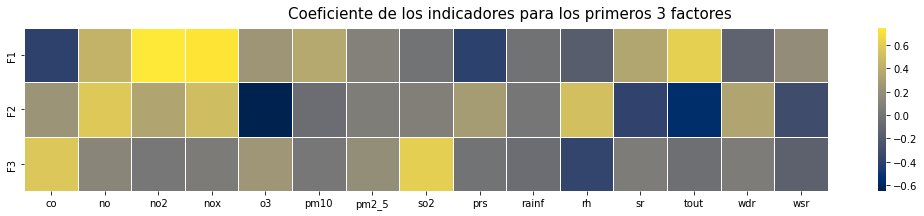

In [12]:
fig, ax = plt.subplots(figsize=(18, 3))

sns.heatmap(factors.loc[:, :2].T, cmap='cividis',
            linewidths=0.5, ax=ax, yticklabels=['F1', 'F2', 'F3'])

ax.set_xlabel(None)
_ = fig.suptitle('Coeficiente de los indicadores para los primeros 3 factores', fontsize=15)

In [13]:

lc = pd.DataFrame(FactorAnalysis(n_components=15).fit_transform(scaled_df),
                  index=scaled_df.index)
# General NO, actividad de coches durante la jornada laboral Día
# Frío y Noche, incrementan moléculas y baja ozono
# CO y SO2, general


In [14]:
exclude_holidays = ['2019-01-01', '2020-01-01',
                    '2019-02-07', '2020-07-02',
                    '2019-05-01', '2020-05-01',
                    '2019-09-16', '2020-09-16',
                    '2019-11-21', '2020-11-21',
                    '2019-12-25', '2020-12-25']

cbh_labor = pd.tseries.offsets.CustomBusinessHour(start="05:00", end="18:00",
                                                  weekmask='1111100',
                                                  holidays=exclude_holidays)

business_timestamps = pd.date_range(start=df.index.min(), end=df.index.max(),
                                    freq=cbh_labor)


In [15]:
df_ = (
    df
    .pipe(janitor.add_columns, 
          labor_activity=df.index.isin(business_timestamps))
)

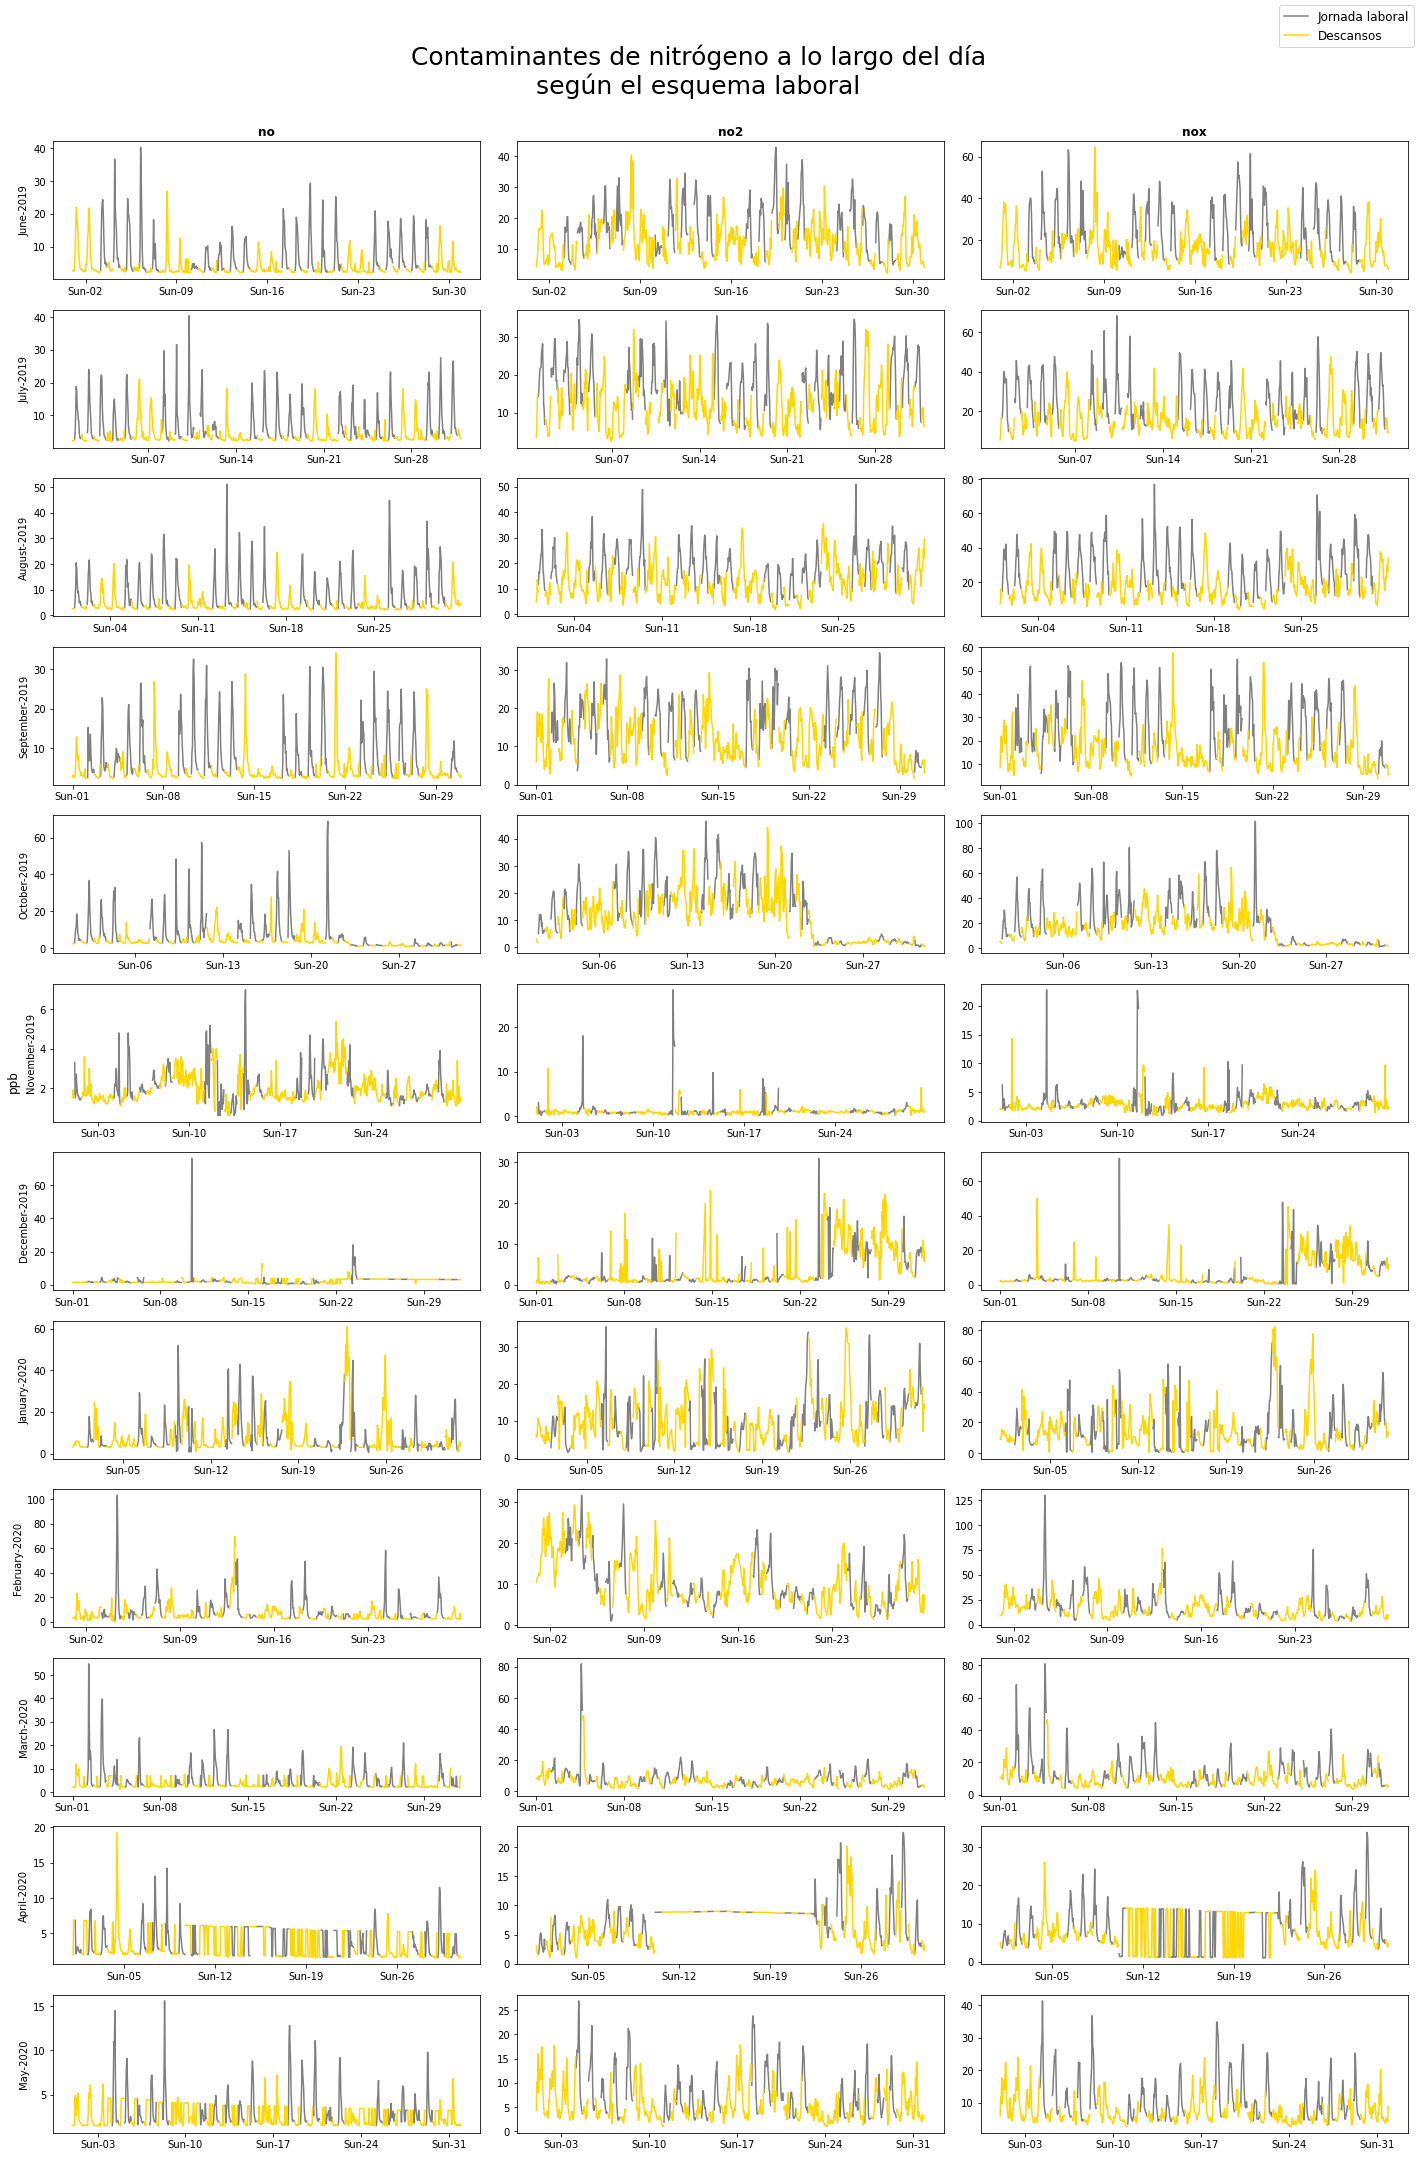

In [16]:
sns.reset_orig()

fig, axes = plt.subplots(12, 3, figsize=(20, 30))
nitrogens = ['no', 'no2', 'nox']

nrow, _ = df_.shape
twelfth = round(nrow/12)

for i in range(12):

    non_labor = df_.copy()
    labor = df_.copy()
    labor[~labor.labor_activity] = np.nan
    non_labor[non_labor.labor_activity] = np.nan
    
    for j, nitrogen in enumerate(nitrogens):
        month = ((i + 5) % 12) + 1 
        labor_data = labor.loc[(labor.index.month == month), nitrogen]
        non_labor_data = non_labor.loc[(non_labor.index.month == month), nitrogen]


        axes[i, j].plot(labor_data, c='gray', label='Jornada laboral')
        axes[i, j].plot(non_labor_data, c='gold', label='Descansos')
        #axes[i, j].legend()

        xticks_ = pd.date_range(start=labor_data.index.min(),
                                end=labor_data.index.max(),
                                freq='W')

        axes[i, j].set_xticks(xticks_)
        axes[i, j].set_xticklabels(xticks_.strftime('%a-%d'))
        # axes[i, j].set_xticklabels(axes[i, j])
        if i == 0:
            axes[i, j].set_title(nitrogen, fontweight='bold')
        if j == 0:
            axes[i, j].set_ylabel(labor_data.index.min().strftime('%B-%Y'), fontsize=10)
    
handles, labels = axes[i, j].get_legend_handles_labels()
fig.legend(handles, labels, prop={'size': 12})

fig.supylabel('ppb')
fig.suptitle('Contaminantes de nitrógeno a lo largo del día\nsegún el esquema laboral', fontsize=25)
fig.tight_layout()
fig.subplots_adjust(top=0.935)

# Daily

In [17]:
daily_scaled_df = scaled_df.groupby(pd.Grouper(freq='d')).mean()

In [18]:
factors = fa_linear_combinations(daily_scaled_df)

Explained variance
0     0.570326
1     0.174475
2     0.159423
3     0.069070
4     0.020622
5     0.006084
6     0.000000
7     0.000000
8     0.000000
9     0.000000
10    0.000000
11    0.000000
12    0.000000
13    0.000000
14    0.000000
dtype: float64


In [19]:
factors.loc[:, [0, 1, 2]]

,0,1,2
factor,,,
co,0.673822,0.312170,-0.253735
no,-0.117070,0.248720,0.182834
no2,-0.472418,0.288631,0.209145
nox,-0.394662,0.292176,0.223436
o3,-0.186640,-0.098172,-0.178145
pm10,-0.321744,0.100336,-0.137871
pm2_5,-0.040486,0.227801,-0.109882
so2,0.217333,0.310563,-0.202165
prs,0.491272,-0.202162,0.309159


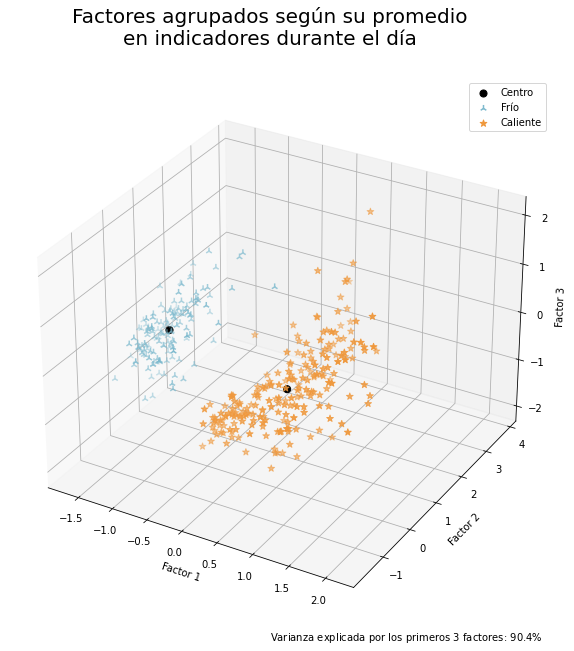

In [20]:

lc = pd.DataFrame(FactorAnalysis(n_components=15).fit_transform(daily_scaled_df),
                  index=daily_scaled_df.index).loc[:, [0, 1, 2]]

# Clustering

kmeans = KMeans(n_clusters=2).fit(lc)
labels = kmeans.predict(lc)
centroids = kmeans.cluster_centers_

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

is_cold = np.array(labels == 0)
is_hot = np.array(labels == 1)

ax.scatter(centroids[:, 0], centroids[:, 1], centroids[:, 2],
           c='black', s=50, label="Centro", alpha=1)

ax.scatter(lc.loc[is_cold, 0], lc.loc[is_cold, 1], lc.loc[is_cold, 2],
           c='#7EBACE', s=50, label='Frío', marker='2')
ax.scatter(lc.loc[is_hot, 0], lc.loc[is_hot, 1], lc.loc[is_hot, 2],
           c='#Ef983C', s=50, label='Caliente', marker='*')

ax.set_xlabel('Factor 1')
ax.set_ylabel('Factor 2')
ax.set_zlabel('Factor 3')
ax.legend()

fig.suptitle(
    'Factores agrupados según su promedio\nen indicadores durante el día', fontsize=20)
_ = fig.text(
    0.5, 0.1, s='Varianza explicada por los primeros 3 factores: $90.4\%$')


# Monthly

In [21]:
monthly_scaled_df = scaled_df.groupby(pd.Grouper(freq='M')).mean()

In [22]:
factors = fa_linear_combinations(monthly_scaled_df)


Explained variance
0     0.593441
1     0.225906
2     0.108882
3     0.037265
4     0.019724
5     0.006004
6     0.003770
7     0.002280
8     0.001868
9     0.000859
10    0.000000
11    0.000000
dtype: float64


In [23]:
factors.loc[:, [0, 1]]
# Mes de frío (nuevamente, coeficientes similares)
# Mes de calor
# Average

,0,1
factor,,
co,0.758565,0.424508
no,-0.188679,0.242812
no2,-0.542368,0.133258
nox,-0.464455,0.171714
o3,-0.113431,-0.110803
pm10,-0.200175,-0.206711
pm2_5,0.020553,0.048792
so2,0.272082,0.238587
prs,0.234562,0.258299


In [24]:
lc.loc[labels == 1, :]

,0,1,2
date,,,
2019-10-23,0.150082,-1.589083,-0.000862
2019-10-24,0.291094,-0.971163,0.016035
2019-10-25,0.366390,-1.399959,-0.149160
2019-10-26,0.387754,-1.116132,-0.560570
2019-10-27,0.149166,-0.202207,-1.626323
...,...,...,...
2020-05-27,0.038762,-0.795470,-0.692794
2020-05-28,0.114911,-0.202518,-0.788186
2020-05-29,0.435161,-0.955677,-0.351825


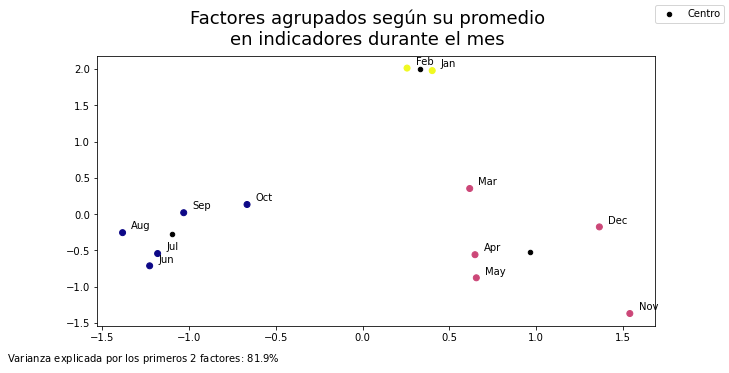

In [25]:
factor_analysis = FactorAnalysis(n_components=15)
lc = pd.DataFrame(factor_analysis.fit_transform(monthly_scaled_df),
                  index=monthly_scaled_df.index).loc[:, [0, 1]]

# Clustering

kmeans = KMeans(n_clusters=3).fit(lc)
labels = kmeans.predict(lc)
centroids = kmeans.cluster_centers_

fig, ax = plt.subplots(figsize=(10, 5))
ax.scatter(centroids[:, 0], centroids[:, 1],
           c="black", s=20, label="Centro", alpha=1)

for k, v in lc.iterrows():
    ax.annotate(k.strftime('%b'), v+0.05)

ax.scatter(x=lc[0], y=lc[1], c=labels, cmap='plasma')

fig.suptitle('Factores agrupados según su promedio\nen indicadores durante el mes', fontsize=18)
#fig.tight_layout()
fig.subplots_adjust(top=0.85, bottom=0.1)
fig.legend()
_ = fig.text(0, 0, s='Varianza explicada por los primeros 2 factores: $81.9\%$')


In [26]:
# Temperatura promedio durante cada mes,
# sigue el mismo orden que los clusters

df.tout.groupby(pd.Grouper(freq='M')).mean().sort_values()

date
2020-01-31    16.277099
2020-02-29    16.400734
2019-12-31    16.878079
2019-11-30    17.696990
2020-03-31    22.331716
2019-10-31    23.552449
2020-04-30    24.041086
2020-05-31    25.819960
2019-09-30    26.219366
2019-07-31    28.444045
2019-06-30    28.520730
2019-08-31    29.727411
Name: tout, dtype: float64